# 라이브러리 가져오기

In [ ]:
!pip install pycaret
!pip install scikit-learn
!pip install optuna
!pip install xgboost
!pip install catboost
!pip install lightgbm

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import random
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import VotingRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

RANDOM_SEED = 42

# 데이터 가져오기

In [ ]:
train       = pd.read_csv('train.csv')
orginal     = pd.read_csv('abalone.csv')
test        = pd.read_csv('test.csv')

In [ ]:
# train 데이터 확인
train.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


In [ ]:
# test 데이터 확인
test.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight
0,90615,M,0.645,0.475,0.155,1.2380,0.6185,0.3125,0.3005
1,90616,M,0.580,0.460,0.160,0.9830,0.4785,0.2195,0.2750
2,90617,M,0.560,0.420,0.140,0.8395,0.3525,0.1845,0.2405
3,90618,M,0.570,0.490,0.145,0.8740,0.3525,0.1865,0.2350
4,90619,I,0.415,0.325,0.110,0.3580,0.1575,0.0670,0.1050


In [ ]:
# abalone 데이터 확인
orginal.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [ ]:
# 데이터 shape 확인
train.shape, orginal.shape, test.shape

((90615, 10), (4177, 9), (60411, 9))

In [ ]:
# id 삭제
train = train.drop(['id'], axis = 1)
train.columns = orginal.columns

In [ ]:
# id 삭제된 train 데이터 확인
train.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


In [ ]:
# id 삭제된 train 데이터 shape 확인
train.shape

(90615, 9)

## 데이터 병합

In [ ]:
# train데이터와 orginal(abalone)데이터 병합
train = pd.concat([train, orginal], axis = 0, ignore_index=True)
train.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


In [ ]:
# 데이터 요약
train.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,94792.000000,94792.000000,94792.000000,94792.000000,94792.000000,94792.000000,94792.000000,94792.000000
mean,0.517402,0.401952,0.135643,0.790785,0.341597,0.169914,0.226468,9.707233
std,0.118308,0.098088,0.038193,0.459231,0.205267,0.101334,0.130639,3.178704
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.445000,0.345000,0.110000,0.419500,0.177500,0.086500,0.120000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.330000,0.166000,0.225000,9.000000
75%,0.600000,0.470000,0.160000,1.072500,0.464500,0.233000,0.305000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [ ]:
## 피쳐 추가
# train['Shucked_Weight_Ratio'] = train['Shucked weight'] / train['Whole weight']
# train['Viscera_Weight_Ratio'] = train['Viscera weight'] / train['Whole weight']
# train['Shell_Weight_Ratio'] = train['Shell weight']   / train['Whole weight']

## train['Weight_remains'] = train['Whole weight']   - train['Shucked weight'] -train['Viscera weight'] - train['Shell weight']
# train["Volume"] = train["Length"] * train["Diameter"] * train["Height"]

# test['Shucked_Weight_Ratio'] = test['Shucked weight'] / test['Whole weight']
# test['Viscera_Weight_Ratio'] = test['Viscera weight'] / test['Whole weight']
# test['Shell_Weight_Ratio'] = test['Shell weight']   / test['Whole weight']

## test['Weight_remains'] = test['Whole weight'] - test['Shucked weight'] -test['Viscera weight'] - test['Shell weight']
# test["Volume"] = test["Length"] * test["Diameter"] * test["Height"]

# pd.concat([train.head(3), test.head(3)], sort=False)

- 새로운 피쳐 생성하여 임계값 조정도 해보고 로그 변환도 시켜봤지만 성능이 계속 저하되어서 원본 데이터로만 사용하기로 결정

In [ ]:
# 병합된 데이터 shape 확인
train.shape

(94792, 9)

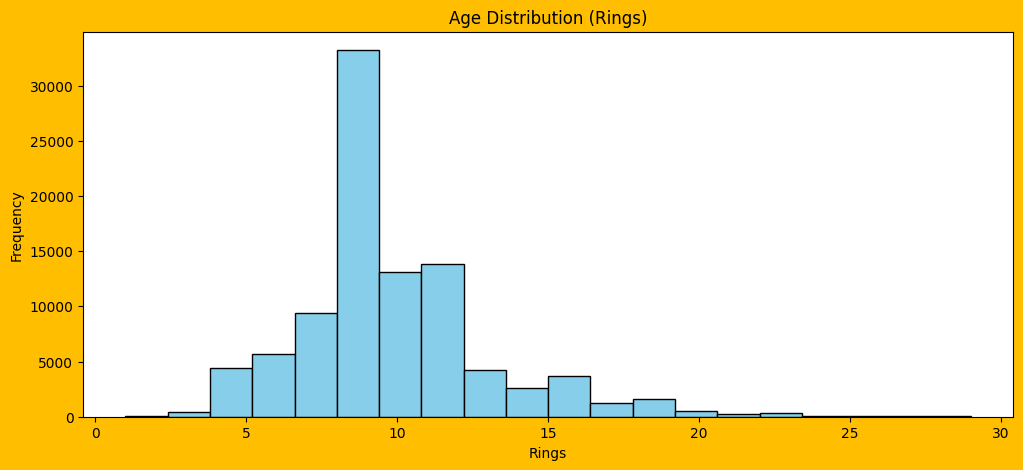

In [ ]:
# 전복 나이(Rings) 분포도 시각화
plt.figure(figsize=(12, 5))
plt.hist(train['Rings'], bins=20, color='skyblue', edgecolor='black')
plt.title('Age Distribution (Rings)')
plt.xlabel('Rings')
plt.gcf().set_facecolor('#FFBF00')
plt.ylabel('Frequency')
plt.show()

## 로그 변환

In [ ]:
y = train['Rings']
y_log = np.log(1+y) # 값이 음수거나 0일때 로그변환하면 사용할 수 없어서 1을 더한다.

In [ ]:
# 로그 변환 전
y.head()

0    11
1    11
2     6
3    10
4     9
Name: Rings, dtype: int64

In [ ]:
# 로그 변환 후
y_log.head()

0    2.484907
1    2.484907
2    1.945910
3    2.397895
4    2.302585
Name: Rings, dtype: float64

In [ ]:
# train데이터에서 피쳐 데이터 Rings 삭제
train = train.drop(['Rings'], axis = 1)
train.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight
0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400
1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200
2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050
3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500
4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975


In [ ]:
# submission id에 대입하기 위한 변수 test_id(test데이터에서 id데이터 삭제하기 전에 미리 저장)
test_id = test['id']
# test데이터에서 id 삭제
test = test.drop('id', axis = 1)
# test데이터의 컬럼들을 train데이터의 컬럼과 동일하게
test.columns = train.columns
test.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight
0,M,0.645,0.475,0.155,1.2380,0.6185,0.3125,0.3005
1,M,0.580,0.460,0.160,0.9830,0.4785,0.2195,0.2750
2,M,0.560,0.420,0.140,0.8395,0.3525,0.1845,0.2405
3,M,0.570,0.490,0.145,0.8740,0.3525,0.1865,0.2350
4,I,0.415,0.325,0.110,0.3580,0.1575,0.0670,0.1050


# EDA

In [ ]:
# train 데이터 정보 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94792 entries, 0 to 94791
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             94792 non-null  object 
 1   Length          94792 non-null  float64
 2   Diameter        94792 non-null  float64
 3   Height          94792 non-null  float64
 4   Whole weight    94792 non-null  float64
 5   Shucked weight  94792 non-null  float64
 6   Viscera weight  94792 non-null  float64
 7   Shell weight    94792 non-null  float64
dtypes: float64(7), object(1)
memory usage: 5.8+ MB


In [ ]:
# test 데이터 정보 확인
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60411 entries, 0 to 60410
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             60411 non-null  object 
 1   Length          60411 non-null  float64
 2   Diameter        60411 non-null  float64
 3   Height          60411 non-null  float64
 4   Whole weight    60411 non-null  float64
 5   Shucked weight  60411 non-null  float64
 6   Viscera weight  60411 non-null  float64
 7   Shell weight    60411 non-null  float64
dtypes: float64(7), object(1)
memory usage: 3.7+ MB


In [ ]:
# train 누락된 값 확인
train.isna().sum()

Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Shucked weight    0
Viscera weight    0
Shell weight      0
dtype: int64

In [ ]:
# test 누락된 값 확인
test.isna().sum()

Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Shucked weight    0
Viscera weight    0
Shell weight      0
dtype: int64

In [ ]:
pd.DataFrame(train.nunique())

# 모든 열에 누락/null 값이 없음

,0
Sex,3
Length,157
Diameter,126
Height,90
Whole weight,3205
Shucked weight,1806
Viscera weight,983
Shell weight,1132


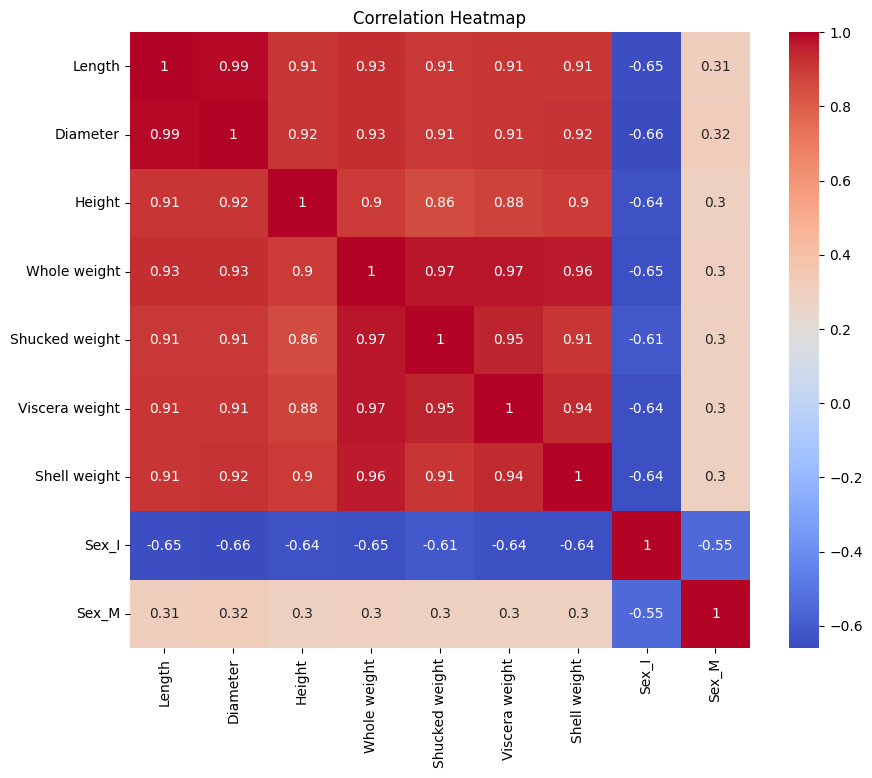

In [ ]:
# 수치 특징과 목표 변수 간의 상관관계 시각화
train_Visual = pd.get_dummies(train, columns=['Sex'], drop_first=True)

plt.figure(figsize=(10, 8))
sns.heatmap(train_Visual.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

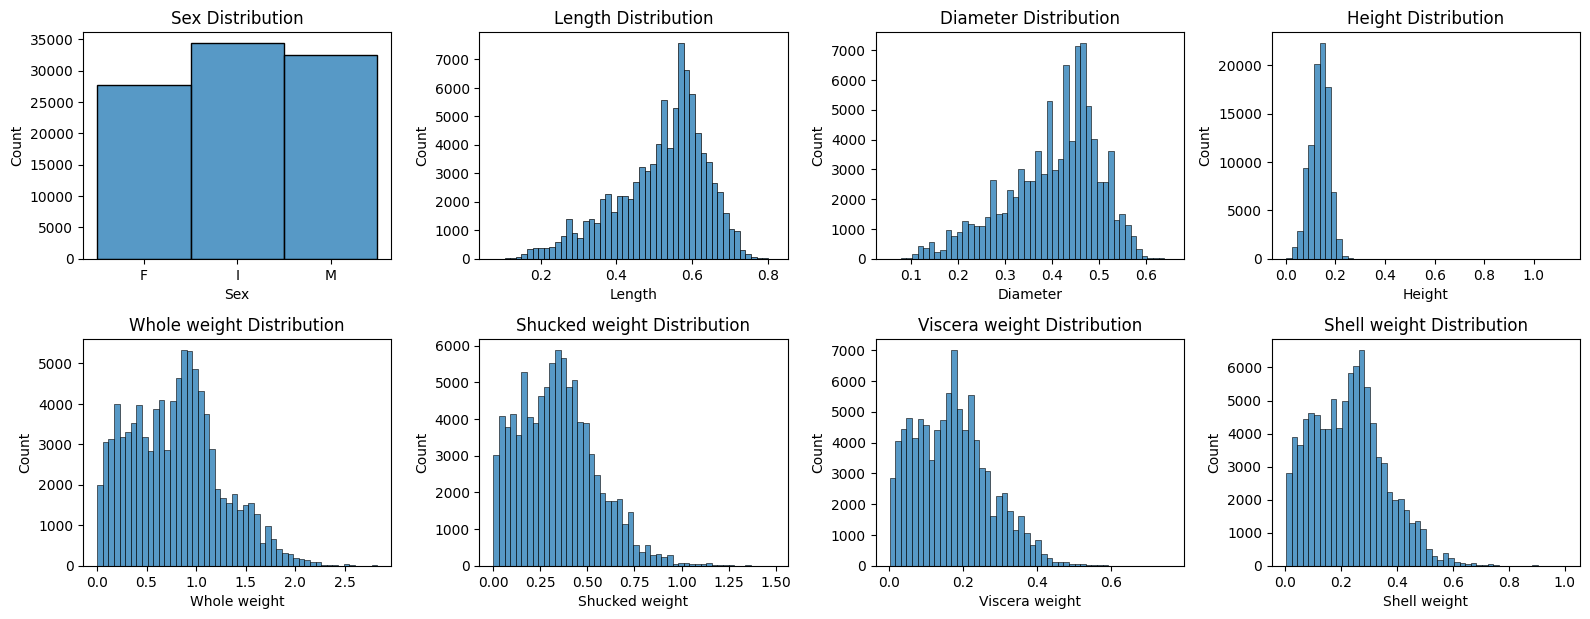

In [ ]:
# 각 데이터들 분포
num_cols = len(train.columns)
plt.figure(figsize=(16, num_cols*1.5))
for i, col in enumerate(train.columns):
    plt.subplot(num_cols//2 + num_cols%2, 4, i + 1)
    sns.histplot(x=col, data=train, bins=50)
    plt.title(f'{col} Distribution')
    plt.tight_layout()
plt.show()

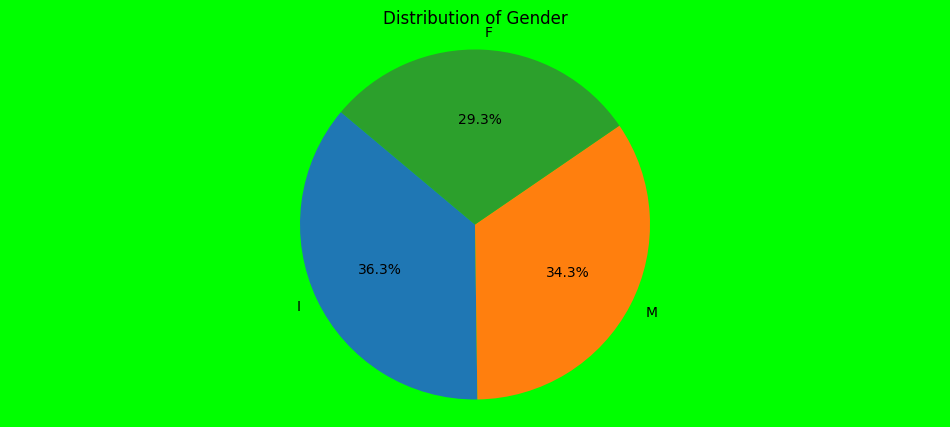

In [ ]:
# 성별 비율
gender_counts = train['Sex'].value_counts()
plt.figure(figsize=(12, 5))
plt.pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Distribution of Gender')
plt.gcf().set_facecolor('#00FF00')
plt.show()

# 원핫인코딩

In [ ]:
encoder = OneHotEncoder(sparse_output = False, handle_unknown = 'ignore')

train = pd.concat([
                    train.iloc[:,1:],
                    pd.DataFrame(encoder.fit_transform(train[['Sex']]).astype('int'),
                                 columns = encoder.categories_[0])
                    ],
                    axis = 1
                )

test  = pd.concat([
                    test.iloc[:,1:],
                    pd.DataFrame(encoder.transform(test[['Sex']]).astype('int'),
                                 columns = encoder.categories_[0])
                    ],
                    axis = 1
                )

In [ ]:
# train데이터에 원핫인코딩 적용되었는지 확인
train.head()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,F,I,M
0,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,1,0,0
1,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,1,0,0
2,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,0,1,0
3,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,0,0,1
4,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,0,1,0


In [ ]:
# test데이터에 원핫인코딩 적용되었는지 확인
test.head()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,F,I,M
0,0.645,0.475,0.155,1.2380,0.6185,0.3125,0.3005,0,0,1
1,0.580,0.460,0.160,0.9830,0.4785,0.2195,0.2750,0,0,1
2,0.560,0.420,0.140,0.8395,0.3525,0.1845,0.2405,0,0,1
3,0.570,0.490,0.145,0.8740,0.3525,0.1865,0.2350,0,0,1
4,0.415,0.325,0.110,0.3580,0.1575,0.0670,0.1050,0,1,0


In [ ]:
def root_mean_squared_log_error(y_true, y_pred):
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))

In [ ]:
# 각 모델들의 최적화된 하이퍼 파라미터 값
# 디폴트값과 GridSearch와 캐글의 작성자들이 optuna 돌려서 얻어낸 최적화 값 모두 비교해 봤을 때,

def get_cv_estimators():
    xgboost_params = {
        'verbosity': 0,
        # 기존 max_depth = 10
        # 첫번째 변경 = 20
        # 두번째 변경 = 25
        # 최종 사용 = 20
        'max_depth': 20,
        'device': 'cuda',
        'booster': 'dart',
        'eval_metric': 'rmsle',
        'random_state': RANDOM_SEED,
        'lambda': 0.456836886068415,
        'alpha': 0.6422509164613671,
        'subsample': 0.8365423486036913,
        'objective': 'reg:squaredlogerror',
        # 기존 learning_rate : 0.09884907639400813
        # 첫번째 변경 = 0.0955
        # 두번째 변경 = 0.09584907639400813
        # 최종 사용 = 0.0955
        'learning_rate': 0.0955,
        'colsample_bytree': 0.8111849113860014,
    }

    catboost_params = {
        # 기존 depth = 15
        # 첫번째 변경 = 20
        # 두번째 변경 = 25
        # 최종 사용 = 20
        'depth': 20,
        'max_bin': 464,
        'verbose': False,
        'task_type': 'CPU',
        'eval_metric': 'RMSE',
        'min_data_in_leaf': 78,
        'loss_function': 'RMSE',
        'grow_policy': 'Lossguide',
        'random_state': RANDOM_SEED,
        'bootstrap_type': 'Bernoulli',
        'subsample': 0.83862137638162,
        'l2_leaf_reg': 8.365422739510098,
        'random_strength': 3.296124856352495,
        # 기존 learning_rate : 0.09992185242598203
        # 첫번째 변경 = 0.0955
        # 두번째 변경 = 0.09592185242598203
        # 최종 사용 = 0.0955
        'learning_rate': 0.0955,
    }

    lgbm_params = {
        'verbosity': -1,
        'device': 'cpu',
        'metric': 'rmse',
        # 기존 num_leaves = 176
        # 첫번째 변경 = 200
        # 두번째 변경 = 220
        # 최종 사용 = 200
        'num_leaves': 200,
        'bagging_freq': 7,
        'boosting_type': 'gbdt',
        'min_child_samples': 91,
        'objective': 'regression',
        'random_state': RANDOM_SEED,
        # 기존 learning_rate = 0.07351805347801958
        # 첫번째 변경 = 0.0955
        # 두번째 변경 = 0.095351805347801958
        # 최종 사용 = 0.0955
        'learning_rate': 0.0955,
        'bagging_fraction': 0.6502062728410578,
        'feature_fraction': 0.7058843944694884,
    }

    cv_estimators = [
        ('lgbm', LGBMRegressor(**lgbm_params)),
        ('xgboost', XGBRegressor(**xgboost_params)),
        ('catboost', CatBoostRegressor(**catboost_params))
    ]
    return cv_estimators

In [ ]:
cv_estimators=get_cv_estimators()

In [ ]:
weight_best_params = {
    'lgbm_weight': 2.704098705074571,
    'xgboost_weight': 0.7975293054707728,
    'catboost_weight': 4.383257916855633,
}


voting_regressor = VotingRegressor(
    estimators=cv_estimators,
    weights=[ weight_best_params['lgbm_weight'],
              weight_best_params['xgboost_weight'],
              weight_best_params['catboost_weight']
    ]
)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)
scores = []
y_pred_test = []
for fold_i, (train_index, valid_index) in enumerate(cv.split(train, y)):
    X_train, y_train = train.iloc[train_index], y_log.iloc[train_index]
    X_valid, y_valid = train.iloc[valid_index], y_log.iloc[valid_index]
    voting_regressor.fit(X_train, y_train)
    y_pred = voting_regressor.predict(X_valid)
    score = root_mean_squared_log_error(y_valid, y_pred)
    scores.append(score)
    y_pred_test.append(voting_regressor.predict(test))
    print(f"FOLD {fold_i} Done. RMSLE : {score}")
print(f"All FOLD. Mean RMSLE : {np.mean(scores)}")

FOLD 0 Done. RMSLE : 0.054143100507781025
FOLD 1 Done. RMSLE : 0.053760965434197214
FOLD 2 Done. RMSLE : 0.05415155758817928
FOLD 3 Done. RMSLE : 0.05391222882266786
FOLD 4 Done. RMSLE : 0.05401354360161447
FOLD 5 Done. RMSLE : 0.05428037350443267
FOLD 6 Done. RMSLE : 0.054133377219706326
FOLD 7 Done. RMSLE : 0.05455096774974294
All FOLD. Mean RMSLE : 0.05411826430354022


# submission 생성 및 제출

## 앙상블 하기 전 확인용

In [ ]:
predictions = np.mean(y_pred_test, axis=0)
sub  = pd.DataFrame(columns = ['id', 'Rings'])
sub['id'] = test_id
sub['Rings'] = np.exp(predictions)-1
sub.to_csv('submission_voting_fold14(최종).csv', index = False)

In [ ]:
sub.head()

## 앙상블

In [ ]:
target=["Rings"]

In [ ]:
# 제출했을 때 가장 결과 좋은 순
# 과적합까지 고려했을 때, 제출 점수가 높은 순서대로 top3를 정해서 앙상블 적용
submission1=pd.read_csv("submission_voting_fold11(최종).csv")
submission2=pd.read_csv("submission_voting_fold13(최종).csv")
submission3=pd.read_csv("submission_voting_fold14(최종).csv")

In [ ]:
sub_list=[submission1,submission2, submission3]

In [ ]:
weights=[1, 1, 1]

In [ ]:
if len(sub_list)==len(weights):
    weighted_list = [item for sublist, weight in zip(sub_list, weights) for item in [sublist] * weight]

In [ ]:
def ensemble_mean(sub_list,cols, mean="AM"):

    """
    The function computes Arithmetic Mean/Geometric Mean/Harmonic Mean given a list of results with specific results.
    """

    sub_out=sub_list[0].copy()
    if mean=="AM":
        for col in cols:
            sub_out[col]=sum(df[col] for df in sub_list)/len(sub_list)
    elif mean=="GM":
        for df in sub_list[1:]:
            for col in cols:
                sub_out[col]*=df[col]
        for col in cols:
            sub_out[col]=(sub_out[col])**(1/len(sub_list))
    elif mean=="HM":
        for col in cols:
            sub_out[col]=len(sub_list)/sum(1/df[col] for df in sub_list)

    return sub_out

In [ ]:
sub_ensemble=ensemble_mean(weighted_list,target,mean="HM")
sub_ensemble.head()

,id,Rings
0,90615,9.742815
1,90616,9.737739
2,90617,9.829230
3,90618,10.444983
4,90619,7.601952


In [ ]:
sub_ensemble.shape

(60411, 2)

In [ ]:
sub_ensemble.to_csv("voting_fold_top3(가중치_1, 1, 1).csv",index = False)